In [1]:
# =========================================================
# Install dependencies (runs once per session)
# =========================================================
!pip -q install -U transformers datasets accelerate evaluate scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 81.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 95.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 45.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.8 MB/s 

# Imports & Configurations

In [2]:
import os, numpy as np, torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
)
import evaluate
from torch import nn
from dataclasses import dataclass

# -----------------------
# Config
# -----------------------
CFG = {
    "teacher_model": "xlm-roberta-base",
    "student_model": "roberta-base",
    "dataset_name": "khondoker/SentNoB",
    "num_labels": 3,
    "max_len": 128,
    "t_epochs": 3,
    "t_lr": 3e-5,
    "t_train_bs": 16,
    "t_grad_accum": 2,
    "s_epochs": 6,
    "s_lr": 3e-5,
    "s_train_bs": 16,
    "s_grad_accum": 2,
    "alpha": 0.5,
    "temperature": 2.0,
    "seed": 42,
    "output_dir": "/kaggle/working/bn_kd_sentnob",
}

os.makedirs(CFG["output_dir"], exist_ok=True)
set_seed(CFG["seed"])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)


2025-10-21 13:39:15.786870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761053956.187768      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761053956.299998      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Using device: cuda


# Load Dataset & Define Metrics

In [3]:
# -----------------------
# Load SentNoB dataset
# -----------------------
ds = load_dataset(CFG["dataset_name"])
print(ds)

# Label mapping
label_names = ["neutral", "positive", "negative"]
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {n: i for i, n in enumerate(label_names)}

# -----------------------
# Metrics
# -----------------------
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }


README.md:   0%|          | 0.00/872 [00:00<?, ?B/s]

Test.csv: 0.00B [00:00, ?B/s]

Train.csv: 0.00B [00:00, ?B/s]

Val.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/15728 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 15728
    })
})


In [4]:
from datasets import load_dataset, DatasetDict

# -----------------------
# Load SentNoB dataset
# -----------------------
ds = load_dataset(CFG["dataset_name"])
print(ds)
print("Available splits:", ds.keys())

# -----------------------
# Handle different split cases
# -----------------------
if list(ds.keys()) == ["train"]:
    # Only one split: create val and test manually
    temp = ds["train"].train_test_split(test_size=0.2, seed=CFG["seed"])  # 80/20 → temp_train/test
    val_test = temp["test"].train_test_split(test_size=0.5, seed=CFG["seed"])  # split 20% into val/test (10/10)
    ds = DatasetDict({
        "train": temp["train"],
        "validation": val_test["train"],
        "test": val_test["test"]
    })
    print("✅ Created train/validation/test splits manually.")
    
elif list(ds.keys()) == ["train", "test"]:
    # Create validation only
    temp = ds["train"].train_test_split(test_size=0.1, seed=CFG["seed"])
    ds = DatasetDict({
        "train": temp["train"],
        "validation": temp["test"],
        "test": ds["test"]
    })
    print("✅ Created validation split (10% of train).")

else:
    print("✅ Dataset already has all splits.")

print(ds)


DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 15728
    })
})
Available splits: dict_keys(['train'])
✅ Created train/validation/test splits manually.
DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 12582
    })
    validation: Dataset({
        features: ['Data', 'Label'],
        num_rows: 1573
    })
    test: Dataset({
        features: ['Data', 'Label'],
        num_rows: 1573
    })
})


In [5]:
print(ds["train"].column_names)


['Data', 'Label']


# Train Teacher (XLM-RoBERTa)

In [6]:
# =========================================================
# Train TEACHER (XLM-RoBERTa)
# =========================================================
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

t_tokenizer = AutoTokenizer.from_pretrained(CFG["teacher_model"])
t_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["teacher_model"], num_labels=CFG["num_labels"],
    id2label=id2label, label2id=label2id
).to(device)

# 🔧 Use correct column names: "Data" and "Label"
def t_tokenize(batch):
    return t_tokenizer(batch["Data"], truncation=True, max_length=CFG["max_len"])

# Use correct names here
t_ds = ds.map(t_tokenize, batched=True, remove_columns=["Data"])
t_ds = t_ds.rename_column("Label", "labels")

t_collator = DataCollatorWithPadding(tokenizer=t_tokenizer)

t_args = TrainingArguments(
    output_dir=os.path.join(CFG["output_dir"], "teacher"),
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=CFG["t_train_bs"],
    per_device_eval_batch_size=CFG["t_train_bs"],
    gradient_accumulation_steps=CFG["t_grad_accum"],
    num_train_epochs=CFG["t_epochs"],
    learning_rate=CFG["t_lr"],
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
)

t_trainer = Trainer(
    model=t_model,
    args=t_args,
    train_dataset=t_ds["train"],
    eval_dataset=t_ds["validation"],
    tokenizer=t_tokenizer,
    data_collator=t_collator,
    compute_metrics=compute_metrics,
)

print("=== Training TEACHER ===")
t_trainer.train()

t_metrics = t_trainer.evaluate(t_ds["test"])
print("✅ Teacher Test Metrics:", t_metrics)

t_save_dir = os.path.join(CFG["output_dir"], "teacher_best")
t_trainer.save_model(t_save_dir)
t_tokenizer.save_pretrained(t_save_dir)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

/tmp/ipykernel_37/151376472.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  t_trainer = Trainer(


=== Training TEACHER ===


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.947500,0.808355,0.640814,0.608545
2,0.738700,0.730396,0.696122,0.648917
3,0.640100,0.763294,0.690401,0.655417


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Teacher Test Metrics: {'eval_loss': 0.733409583568573, 'eval_accuracy': 0.6923076923076923, 'eval_f1_macro': 0.6386808489283413, 'eval_runtime': 7.8058, 'eval_samples_per_second': 201.518, 'eval_steps_per_second': 6.406, 'epoch': 3.0}


('/kaggle/working/bn_kd_sentnob/teacher_best/tokenizer_config.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/special_tokens_map.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/sentencepiece.bpe.model',
 '/kaggle/working/bn_kd_sentnob/teacher_best/added_tokens.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/tokenizer.json')

# Dump Teacher Logits (Optional, Faster KD)

In [7]:
# =========================================================
# Dump Teacher Logits (Fixed for SentNoB column names)
# =========================================================
def dump_teacher_logits(dataset, split_name):
    loader = torch.utils.data.DataLoader(
        dataset.remove_columns(["labels"]),
        batch_size=64, shuffle=False,
        collate_fn=t_collator, pin_memory=True
    )
    all_logits = []
    t_model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = t_model(**batch).logits.detach().cpu()
            all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0).numpy()
    np.save(os.path.join(CFG["output_dir"], f"teacher_logits_{split_name}.npy"), all_logits)
    print(f"💾 Saved teacher logits for {split_name}: {all_logits.shape}")

dump_teacher_logits(t_ds["train"], "train")
dump_teacher_logits(t_ds["validation"], "validation")
dump_teacher_logits(t_ds["test"], "test")


💾 Saved teacher logits for train: (12582, 3)
💾 Saved teacher logits for validation: (1573, 3)
💾 Saved teacher logits for test: (1573, 3)


# Prepare Student Dataset & Attach Teacher Logits

In [8]:
# =========================================================
# Prepare Student Dataset & Attach Teacher Logits (Foolproof)
# =========================================================
from datasets import load_from_disk

# if cached previous maps exist, remove them to prevent stale data
from shutil import rmtree
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    print("🧹 Clearing HF dataset cache to avoid stale maps...")
    rmtree(cache_dir)

s_tokenizer = AutoTokenizer.from_pretrained(CFG["student_model"])
s_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["student_model"], num_labels=CFG["num_labels"],
    id2label=id2label, label2id=label2id
).to(device)

# -----------------------------
# Tokenize student data
# -----------------------------
def s_tokenize(batch):
    return s_tokenizer(batch["Data"], truncation=True, max_length=CFG["max_len"])

s_ds = ds.map(
    s_tokenize,
    batched=True,
    remove_columns=["Data"],
    load_from_cache_file=False,
    desc="Tokenizing student dataset"
)
s_ds = s_ds.rename_column("Label", "labels")
s_collator = DataCollatorWithPadding(tokenizer=s_tokenizer)

# -----------------------------
# Load teacher logits (.npy)
# -----------------------------
t_train_logits = np.load(os.path.join(CFG["output_dir"], "teacher_logits_train.npy"))
t_val_logits   = np.load(os.path.join(CFG["output_dir"], "teacher_logits_validation.npy"))
t_test_logits  = np.load(os.path.join(CFG["output_dir"], "teacher_logits_test.npy"))

print("Logit vs split sizes:",
      t_train_logits.shape[0], len(s_ds["train"]),
      t_val_logits.shape[0], len(s_ds["validation"]),
      t_test_logits.shape[0], len(s_ds["test"]))

assert t_train_logits.shape[0] == len(s_ds["train"]), "Train logits count mismatch!"
assert t_val_logits.shape[0]   == len(s_ds["validation"]), "Validation logits count mismatch!"
assert t_test_logits.shape[0]  == len(s_ds["test"]), "Test logits count mismatch!"

# -----------------------------
# Attach teacher logits
# -----------------------------
def add_teacher_logits(example, idx, split_name):
    if split_name == "train":
        example["teacher_logits"] = list(map(float, t_train_logits[idx]))
    elif split_name == "validation":
        example["teacher_logits"] = list(map(float, t_val_logits[idx]))
    else:
        example["teacher_logits"] = list(map(float, t_test_logits[idx]))
    return example

s_ds["train"] = s_ds["train"].map(lambda ex, i: add_teacher_logits(ex, i, "train"),
                                  with_indices=True, load_from_cache_file=False)
s_ds["validation"] = s_ds["validation"].map(lambda ex, i: add_teacher_logits(ex, i, "validation"),
                                            with_indices=True, load_from_cache_file=False)
s_ds["test"] = s_ds["test"].map(lambda ex, i: add_teacher_logits(ex, i, "test"),
                                with_indices=True, load_from_cache_file=False)

# -----------------------------
# Verify
# -----------------------------
print("Columns:", s_ds["train"].column_names)
print("Example:", s_ds["train"][0])
print("✅ All splits now include 'teacher_logits'.")


🧹 Clearing HF dataset cache to avoid stale maps...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing student dataset:   0%|          | 0/12582 [00:00<?, ? examples/s]

Tokenizing student dataset:   0%|          | 0/1573 [00:00<?, ? examples/s]

Tokenizing student dataset:   0%|          | 0/1573 [00:00<?, ? examples/s]

Logit vs split sizes: 12582 12582 1573 1573 1573 1573


Map:   0%|          | 0/12582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
Example: {'labels': 1, 'input_ids': [0, 35861, 25448, 12798, 6248, 10172, 35861, 11582, 1437, 35861, 25448, 35861, 4726, 35861, 6382, 35861, 10470, 12798, 6248, 6382, 1437, 35861, 6382, 35861, 15113, 12798, 6248, 8384, 35861, 3726, 12798, 6248, 6382, 1437, 35861, 15722, 35861, 7487, 35861, 10470, 12798, 6248, 6382, 35861, 3726, 12798, 6248, 6382, 2156, 1437, 35861, 27819, 35861, 10278, 35861, 11423, 35861, 9470, 35861, 10470, 12798, 6248, 13859, 1437, 35861, 18537, 12798, 6248, 6382, 35861, 6382, 1437, 35861, 25448, 35861, 4726, 35861, 6382, 35861, 10470, 12798, 6248, 6382, 1437, 35861, 10278, 35861, 4726, 35861, 7487, 12798, 6248, 6382, 35861, 11423, 2156, 1437, 35861, 9357, 35861, 15722, 35861, 18164, 35861, 9470, 35861, 11423, 1437, 35861, 27819, 35861, 10278, 35861, 11423, 35861, 4726, 35861, 7487, 1437, 35861, 18537, 35861, 4726, 35861, 8210, 12798, 6248, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
print("🔧 Hard rebuilding teacher_logits as pure Python float32 lists...")

for split in ["train", "validation", "test"]:
    if "teacher_logits" in s_ds[split].column_names:
        # Convert each element to a list of float32 scalars (no NumPy)
        new_logits = [
            [float(np.float32(x)) for x in row["teacher_logits"]]
            for row in s_ds[split]
        ]
        # Drop the old column & replace it
        s_ds[split] = s_ds[split].remove_columns("teacher_logits")
        s_ds[split] = s_ds[split].add_column("teacher_logits", new_logits)

print("✅ Done. Now verifying dtype ...")
print("dtype =", type(s_ds["train"][0]["teacher_logits"][0]), 
      "first3 =", s_ds["train"][0]["teacher_logits"][:3])


🔧 Hard rebuilding teacher_logits as pure Python float32 lists...
✅ Done. Now verifying dtype ...
dtype = <class 'float'> first3 = [-1.2301841974258423, 3.263232946395874, -1.564107060432434]


In [10]:
import numpy as np

def check_teacher_logits(ds_dict):
    print("🔍 Checking teacher_logits for each split...\n")
    for split in ["train", "validation", "test"]:
        if split not in ds_dict:
            print(f"❌ Split '{split}' missing entirely.")
            continue

        ds_split = ds_dict[split]
        cols = ds_split.column_names
        print(f"=== {split.upper()} ===")
        print("Columns:", cols)

        # 1️⃣ Check teacher_logits key exists
        if "teacher_logits" not in cols:
            print("❌ teacher_logits column missing.\n")
            continue

        # 2️⃣ Sample first element
        try:
            item = ds_split[0]
            logits = np.array(item["teacher_logits"])
            print(f"✅ teacher_logits found, shape={logits.shape}, dtype={logits.dtype}")
            print(f"Sample logits (first 3): {logits[:3]}")
        except Exception as e:
            print("⚠️ Could not read teacher_logits:", e)

        # 3️⃣ Check alignment with labels
        print(f"Total samples = {len(ds_split)}")
        if "labels" in cols:
            print(f"Labels present. Example label: {item['labels']}")
        print()

# Run check
check_teacher_logits(s_ds)


🔍 Checking teacher_logits for each split...

=== TRAIN ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-1.2301842   3.26323295 -1.56410706]
Total samples = 12582
Labels present. Example label: 1

=== VALIDATION ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-0.03466503  0.33062398 -0.10199504]
Total samples = 1573
Labels present. Example label: 2

=== TEST ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-0.88417315 -1.29122162  2.13488388]
Total samples = 1573
Labels present. Example label: 2



# Define KD Trainer & Train Student (RoBERTa)

In [11]:
# =========================================================
# FINAL FIXED: KD Trainer & Train Student (Fully Working)
# =========================================================
from dataclasses import dataclass
import torch
from torch import nn
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# ✅ Ensure dataset keeps teacher_logits
for split in ["train", "validation", "test"]:
    s_ds[split].set_format(type=None, columns=None)

# ✅ SAFE KDDataCollator
@dataclass
class KDDataCollator:
    base_collator: any
    def __call__(self, features):
        if len(features) == 0 or "teacher_logits" not in features[0]:
            return self.base_collator(features)
        features_copy = [f.copy() for f in features]
        t_logits = torch.tensor(
            [f.pop("teacher_logits") for f in features_copy],
            dtype=torch.float32
        )
        batch = self.base_collator(features_copy)
        batch["teacher_logits"] = t_logits
        return batch

kd_collator = KDDataCollator(base_collator=s_collator)

# ✅ Custom Trainer (KL + CE)
class KDTrainer(Trainer):
    def __init__(self, *args, alpha=0.9, temperature=5.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction="batchmean")

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        teacher_logits = inputs.pop("teacher_logits", None)
        outputs = model(**inputs)
        student_logits = outputs.logits

        # Hard loss
        loss_ce = nn.CrossEntropyLoss()(student_logits, labels)

        # Soft loss (KD)
        if teacher_logits is not None:
            T = self.temperature
            log_p = nn.functional.log_softmax(student_logits / T, dim=-1)
            q = nn.functional.softmax(teacher_logits / T, dim=-1)
            loss_kd = self.kl_div(log_p, q) * (T * T)
            loss = self.alpha * loss_kd + (1 - self.alpha) * loss_ce
        else:
            loss_kd = torch.tensor(-1.0)
            loss = loss_ce

        # --- DEBUG LOG ---
        if self.state.global_step % 100 == 0:
            print(f"[KD] step={self.state.global_step} α={self.alpha} T={self.temperature} "
                  f"loss_ce={loss_ce.item():.4f} loss_kd={(loss_kd.item() if teacher_logits is not None else -1):.4f}")

        return (loss, outputs) if return_outputs else loss


# ✅ TrainingArguments (fixed for KD)
s_args = TrainingArguments(
    output_dir=os.path.join(CFG["output_dir"], "student"),
    eval_strategy="epoch",        # fixed key
    save_strategy="epoch",
    per_device_train_batch_size=CFG["s_train_bs"],
    per_device_eval_batch_size=CFG["s_train_bs"],
    gradient_accumulation_steps=CFG["s_grad_accum"],
    num_train_epochs=CFG["s_epochs"],
    learning_rate=CFG["s_lr"],
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    logging_strategy="steps",
    logging_steps=100,
    remove_unused_columns=False,        # 🚨 critical for KD!
)

# ✅ (Re)initialize Student Model clean
s_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["student_model"],
    num_labels=CFG["num_labels"],
    id2label=id2label,
    label2id=label2id
).to(device)

# ✅ Initialize Trainer
kd_trainer = KDTrainer(
    model=s_model,
    args=s_args,
    train_dataset=s_ds["train"],
    eval_dataset=s_ds["validation"],
    tokenizer=s_tokenizer,
    data_collator=kd_collator,
    compute_metrics=compute_metrics,
    alpha=0.9,          # best from ablation
    temperature=5.0,    # best from ablation
)

print("=== Training STUDENT (RoBERTa with KD) ===")
kd_trainer.train()

# ✅ Evaluate on test
s_metrics = kd_trainer.evaluate(s_ds["test"])
print("✅ Student Test Metrics:", s_metrics)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


=== Training STUDENT (RoBERTa with KD) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=5.0 loss_ce=1.1028 loss_kd=1.0074
[KD] step=0 α=0.9 T=5.0 loss_ce=1.1087 loss_kd=1.4585


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.107600,0.851204,0.495232,0.432973
2,0.873300,0.703435,0.561983,0.514533
3,0.701000,0.697447,0.588048,0.538658
4,0.624200,0.638180,0.589320,0.528919
5,0.555300,0.579556,0.601399,0.549160
6,0.512600,0.572739,0.595677,0.542383


[KD] step=100 α=0.9 T=5.0 loss_ce=1.0347 loss_kd=0.9723
[KD] step=100 α=0.9 T=5.0 loss_ce=0.9878 loss_kd=0.9950


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=5.0 loss_ce=1.0466 loss_kd=0.9920
[KD] step=200 α=0.9 T=5.0 loss_ce=0.9029 loss_kd=0.9258
[KD] step=300 α=0.9 T=5.0 loss_ce=1.1606 loss_kd=0.9845
[KD] step=300 α=0.9 T=5.0 loss_ce=0.9813 loss_kd=0.6450


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=5.0 loss_ce=1.2325 loss_kd=0.7115
[KD] step=400 α=0.9 T=5.0 loss_ce=0.8403 loss_kd=0.7570
[KD] step=500 α=0.9 T=5.0 loss_ce=0.8589 loss_kd=0.6434
[KD] step=500 α=0.9 T=5.0 loss_ce=0.6573 loss_kd=0.4684


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=5.0 loss_ce=0.8001 loss_kd=0.6172
[KD] step=600 α=0.9 T=5.0 loss_ce=0.8125 loss_kd=0.5599
[KD] step=700 α=0.9 T=5.0 loss_ce=0.9749 loss_kd=0.4836
[KD] step=700 α=0.9 T=5.0 loss_ce=1.0109 loss_kd=0.6076


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=5.0 loss_ce=0.9372 loss_kd=0.4969
[KD] step=800 α=0.9 T=5.0 loss_ce=0.8147 loss_kd=0.5890
[KD] step=900 α=0.9 T=5.0 loss_ce=0.9854 loss_kd=0.5549
[KD] step=900 α=0.9 T=5.0 loss_ce=0.8467 loss_kd=0.5976


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=5.0 loss_ce=0.9055 loss_kd=0.6040
[KD] step=1000 α=0.9 T=5.0 loss_ce=0.8926 loss_kd=0.4973
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.6102 loss_kd=0.4225
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.7611 loss_kd=0.4365


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Student Test Metrics: {'eval_loss': 0.5526750683784485, 'eval_accuracy': 0.6198347107438017, 'eval_f1_macro': 0.5632126851120945, 'eval_runtime': 8.11, 'eval_samples_per_second': 193.957, 'eval_steps_per_second': 6.165, 'epoch': 6.0}


In [12]:
sample_texts = [
 # 💚 Positive
  
    "অভিনেতাদের পারফরম্যান্স ছিল চমৎকার।",
    "এই অ্যাপটা আমার অনেক কাজে লাগে।",
    "খাবারের মান ছিল চমৎকার, সার্ভিসও ভালো।",
    "পুরো সিনেমাটা একদম নিখুঁত ছিল!",

    # 💔 Negative
   
    "ডেলিভারি খুব দেরিতে এসেছে, অভিজ্ঞতা খারাপ।",
    "সার্ভিসটা বাজে ছিল, আমি আবার ব্যবহার করব না।",
    "মুভির শেষটা একদম হতাশাজনক।",
    "পণ্যের মান প্রত্যাশার অনেক নিচে।",

    # ⚖️ Neutral / Mixed
    
    "খাবারটা মোটামুটি, দাম একটু বেশি।",
    "মুভিটা ভালো না খারাপ না, মাঝামাঝি।",
    "অ্যাপটা কাজ করে, কিন্তু আরও উন্নতি দরকার।",
]

enc = s_tokenizer(sample_texts, truncation=True, padding=True, max_length=CFG["max_len"], return_tensors="pt").to(device)
s_model.eval()
with torch.no_grad():
    logits = s_model(**enc).logits
preds = logits.argmax(-1).cpu().tolist()

print("Predictions:", [id2label[p] for p in preds])


Predictions: ['positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'neutral', 'neutral']


# t-SNE Visualization: Teacher vs Student Embedding Space

Embedding...: 100%|██████████| 19/19 [00:02<00:00,  7.75it/s]


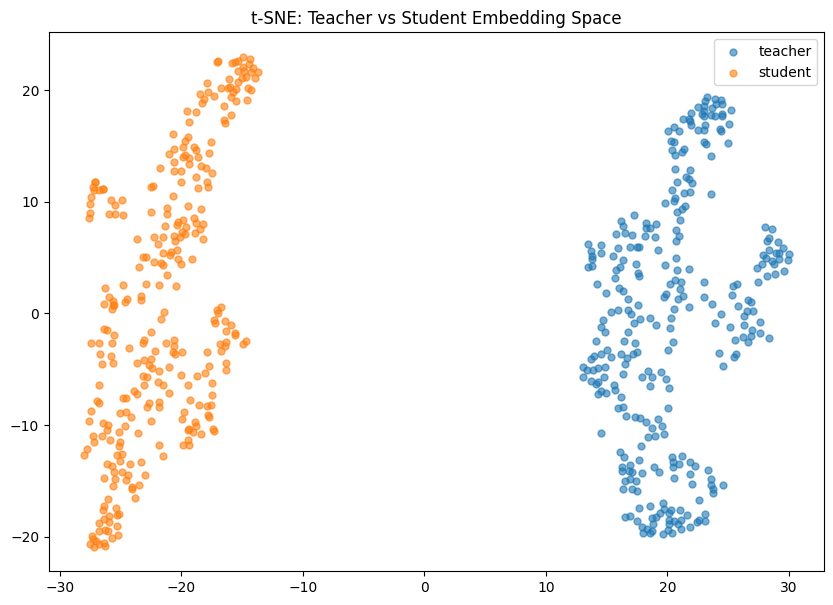

In [13]:
# =========================================================
# t-SNE Visualization of Teacher vs Student Embeddings
# =========================================================
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
from tqdm import tqdm

# Take a small subset for visualization (e.g., 300 examples)
subset = ds["test"].select(range(300))
texts = subset["Data"]
labels = subset["Label"]

def get_embeddings(model, tokenizer, texts, max_len=128):
    model.eval()
    all_embeds = []
    for i in tqdm(range(0, len(texts), 16), desc="Embedding..."):
        batch_texts = texts[i:i+16]
        enc = tokenizer(batch_texts, padding=True, truncation=True,
                        max_length=max_len, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**enc, output_hidden_states=True)
            # CLS token embedding (last layer)
            embeds = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        all_embeds.append(embeds)
    return np.vstack(all_embeds)

# Get embeddings from teacher & student
teacher_emb = get_embeddings(t_model, t_tokenizer, texts)
student_emb = get_embeddings(s_model, s_tokenizer, texts)

# Combine and reduce using t-SNE
combined_emb = np.vstack([teacher_emb, student_emb])
domain_labels = np.array(["teacher"] * len(teacher_emb) + ["student"] * len(student_emb))

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_emb = tsne.fit_transform(combined_emb)

# Plot
plt.figure(figsize=(10, 7))
for domain, color in zip(["teacher", "student"], ["#1f77b4", "#ff7f0e"]):
    mask = domain_labels == domain
    plt.scatter(tsne_emb[mask, 0], tsne_emb[mask, 1], label=domain, alpha=0.6, s=25, c=color)
plt.legend()
plt.title("t-SNE: Teacher vs Student Embedding Space")
plt.show()


# Cosine Similarity Analysis

Mean cosine similarity: 0.2007


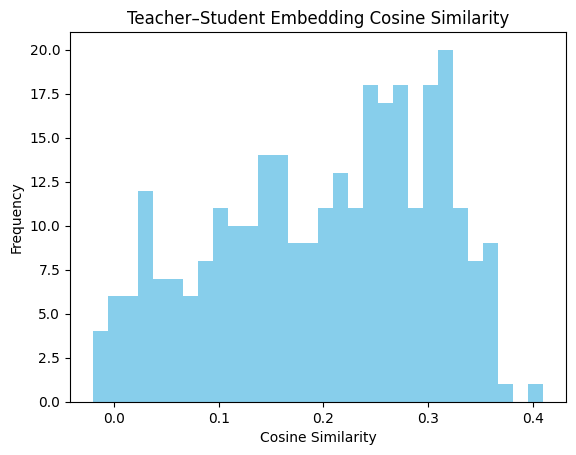

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

sim_scores = []
for i in range(len(teacher_emb)):
    sim = cosine_similarity(teacher_emb[i].reshape(1,-1), student_emb[i].reshape(1,-1))[0][0]
    sim_scores.append(sim)

print(f"Mean cosine similarity: {np.mean(sim_scores):.4f}")
plt.hist(sim_scores, bins=30, color='skyblue')
plt.title("Teacher–Student Embedding Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


🔍 Generating predictions...


,Class,Teacher_F1,Student_F1,Diff
0,neutral,0.395,0.331,-0.063
1,positive,0.761,0.687,-0.073
2,negative,0.761,0.671,-0.090


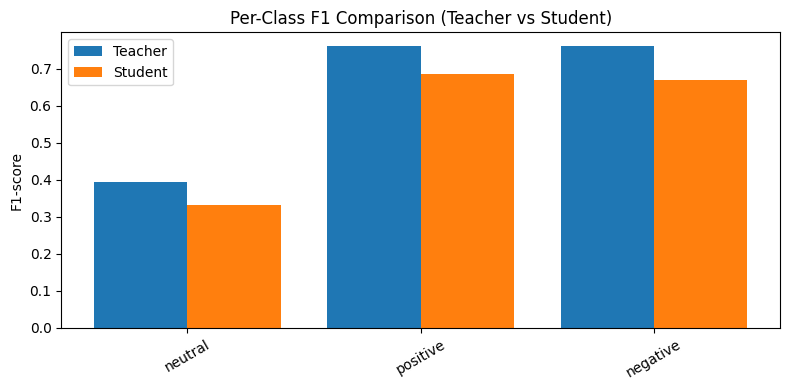

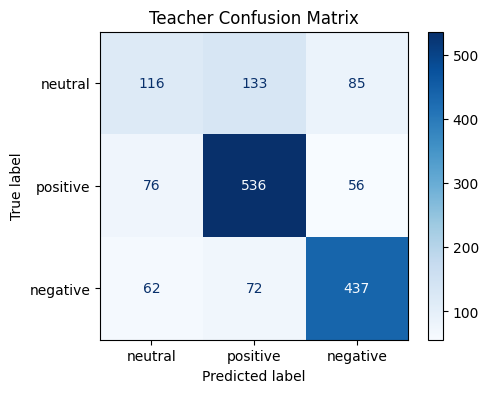

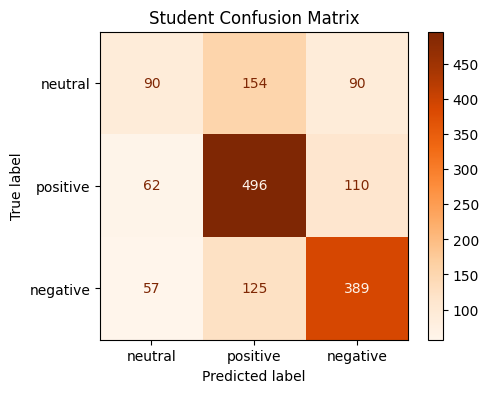

In [15]:
# =========================================================
# Per-Class F1 Comparison + Confusion Matrices (Teacher vs Student)
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import DataCollatorWithPadding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# -------------------------------
# Helper: Get predictions safely (ignores teacher_logits)
# -------------------------------
def get_preds(model, tokenizer, dataset, max_len=CFG["max_len"]):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=DataCollatorWithPadding(tokenizer),
    )
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            lbl = batch["labels"]
            # 🔧 Drop non-model keys
            batch = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "teacher_logits"]}
            logits = model(**batch).logits
            preds.extend(logits.argmax(-1).cpu().tolist())
            labels.extend(lbl.tolist())
    return np.array(preds), np.array(labels)

# -------------------------------
# Get predictions for teacher & student
# -------------------------------
print("🔍 Generating predictions...")
t_preds, y_true = get_preds(t_model, t_tokenizer, t_ds["test"])
s_preds, _ = get_preds(s_model, s_tokenizer, s_ds["test"])

# -------------------------------
# Compute per-class F1-scores
# -------------------------------
target_names = [id2label[i] for i in range(CFG["num_labels"])]

t_report = classification_report(y_true, t_preds, target_names=target_names, output_dict=True)
s_report = classification_report(y_true, s_preds, target_names=target_names, output_dict=True)

df_f1 = pd.DataFrame({
    "Class": target_names,
    "Teacher_F1": [t_report[c]["f1-score"] for c in target_names],
    "Student_F1": [s_report[c]["f1-score"] for c in target_names],
})
df_f1["Diff"] = df_f1["Student_F1"] - df_f1["Teacher_F1"]
display(df_f1.round(3))

# -------------------------------
# Bar plot: per-class F1
# -------------------------------
plt.figure(figsize=(8,4))
x = np.arange(len(df_f1))
plt.bar(x-0.2, df_f1["Teacher_F1"], 0.4, label="Teacher")
plt.bar(x+0.2, df_f1["Student_F1"], 0.4, label="Student")
plt.xticks(x, df_f1["Class"], rotation=30)
plt.ylabel("F1-score")
plt.title("Per-Class F1 Comparison (Teacher vs Student)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Confusion Matrices
# -------------------------------
cm_t = confusion_matrix(y_true, t_preds, labels=list(range(len(target_names))))
cm_s = confusion_matrix(y_true, s_preds, labels=list(range(len(target_names))))

disp_t = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=target_names)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=target_names)

plt.figure(figsize=(5,4))
disp_t.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Teacher Confusion Matrix")
plt.show()

plt.figure(figsize=(5,4))
disp_s.plot(cmap="Oranges", values_format="d", ax=plt.gca())
plt.title("Student Confusion Matrix")
plt.show()


# Ablation Study — α (alpha) and Temperature Sweep


=== Running KD: α=0.5, T=2.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=2.0 loss_ce=0.9087 loss_kd=0.5268
[KD] step=0 α=0.5 T=2.0 loss_ce=1.0750 loss_kd=0.7016


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.671100,0.694081,0.593134,0.553713
2,0.614100,0.665406,0.609663,0.553216
3,0.554800,0.713402,0.604577,0.548612
4,0.521300,0.681603,0.618563,0.556503
5,0.496300,0.665718,0.620470,0.566127
6,0.513900,0.655138,0.616656,0.562140


[KD] step=100 α=0.5 T=2.0 loss_ce=1.0186 loss_kd=0.5656
[KD] step=100 α=0.5 T=2.0 loss_ce=0.7918 loss_kd=0.4464


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=2.0 loss_ce=0.9217 loss_kd=0.4915
[KD] step=200 α=0.5 T=2.0 loss_ce=0.8579 loss_kd=0.4888
[KD] step=300 α=0.5 T=2.0 loss_ce=0.8477 loss_kd=0.4252
[KD] step=300 α=0.5 T=2.0 loss_ce=0.8693 loss_kd=0.3160


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=2.0 loss_ce=0.9967 loss_kd=0.4899
[KD] step=400 α=0.5 T=2.0 loss_ce=0.4876 loss_kd=0.3458
[KD] step=500 α=0.5 T=2.0 loss_ce=0.6708 loss_kd=0.3301
[KD] step=500 α=0.5 T=2.0 loss_ce=0.6422 loss_kd=0.2783


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=2.0 loss_ce=0.6230 loss_kd=0.3539
[KD] step=600 α=0.5 T=2.0 loss_ce=0.5914 loss_kd=0.2079
[KD] step=700 α=0.5 T=2.0 loss_ce=0.6123 loss_kd=0.2738
[KD] step=700 α=0.5 T=2.0 loss_ce=0.6968 loss_kd=0.2834


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=2.0 loss_ce=0.7598 loss_kd=0.2647
[KD] step=800 α=0.5 T=2.0 loss_ce=0.6662 loss_kd=0.3470
[KD] step=900 α=0.5 T=2.0 loss_ce=0.7673 loss_kd=0.3413
[KD] step=900 α=0.5 T=2.0 loss_ce=0.6188 loss_kd=0.2989


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=2.0 loss_ce=0.7202 loss_kd=0.4057
[KD] step=1000 α=0.5 T=2.0 loss_ce=0.6866 loss_kd=0.2875
[KD] step=1100 α=0.5 T=2.0 loss_ce=0.5826 loss_kd=0.3473
[KD] step=1100 α=0.5 T=2.0 loss_ce=0.5751 loss_kd=0.2316


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=3.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=3.0 loss_ce=0.5167 loss_kd=0.2985
[KD] step=0 α=0.5 T=3.0 loss_ce=0.5596 loss_kd=0.2089


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.508300,0.763903,0.596949,0.576286
2,0.466100,0.741326,0.625556,0.576676
3,0.420600,0.745473,0.618563,0.566267
4,0.404600,0.742513,0.623649,0.565044
5,0.400100,0.705593,0.634456,0.590024
6,0.481500,0.670302,0.635092,0.580024


[KD] step=100 α=0.5 T=3.0 loss_ce=0.7939 loss_kd=0.4470
[KD] step=100 α=0.5 T=3.0 loss_ce=0.5346 loss_kd=0.2974


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=3.0 loss_ce=0.6715 loss_kd=0.3463
[KD] step=200 α=0.5 T=3.0 loss_ce=0.7443 loss_kd=0.2297
[KD] step=300 α=0.5 T=3.0 loss_ce=0.6268 loss_kd=0.2170
[KD] step=300 α=0.5 T=3.0 loss_ce=0.8263 loss_kd=0.2812


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=3.0 loss_ce=0.6967 loss_kd=0.3772
[KD] step=400 α=0.5 T=3.0 loss_ce=0.2709 loss_kd=0.2096
[KD] step=500 α=0.5 T=3.0 loss_ce=0.4168 loss_kd=0.1791
[KD] step=500 α=0.5 T=3.0 loss_ce=0.4067 loss_kd=0.1759


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=3.0 loss_ce=0.4097 loss_kd=0.2738
[KD] step=600 α=0.5 T=3.0 loss_ce=0.4215 loss_kd=0.1245
[KD] step=700 α=0.5 T=3.0 loss_ce=0.4703 loss_kd=0.2151
[KD] step=700 α=0.5 T=3.0 loss_ce=0.6615 loss_kd=0.2153


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=3.0 loss_ce=0.5789 loss_kd=0.2741
[KD] step=800 α=0.5 T=3.0 loss_ce=0.5708 loss_kd=0.3042
[KD] step=900 α=0.5 T=3.0 loss_ce=0.6530 loss_kd=0.2862
[KD] step=900 α=0.5 T=3.0 loss_ce=0.4049 loss_kd=0.1995


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=3.0 loss_ce=0.5598 loss_kd=0.3987
[KD] step=1000 α=0.5 T=3.0 loss_ce=0.6799 loss_kd=0.3565
[KD] step=1100 α=0.5 T=3.0 loss_ce=0.5383 loss_kd=0.3107
[KD] step=1100 α=0.5 T=3.0 loss_ce=0.5082 loss_kd=0.1922


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=4.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=4.0 loss_ce=0.3795 loss_kd=0.3046
[KD] step=0 α=0.5 T=4.0 loss_ce=0.3306 loss_kd=0.1993


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.415400,0.750743,0.635092,0.603426
2,0.379100,0.775788,0.624921,0.565834
3,0.373000,0.777961,0.627463,0.577769
4,0.349100,0.733673,0.634456,0.580537
5,0.343300,0.710283,0.636999,0.599996
6,0.451400,0.677557,0.642721,0.588265


[KD] step=100 α=0.5 T=4.0 loss_ce=0.5443 loss_kd=0.2221
[KD] step=100 α=0.5 T=4.0 loss_ce=0.4046 loss_kd=0.1335


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=4.0 loss_ce=0.5971 loss_kd=0.2280
[KD] step=200 α=0.5 T=4.0 loss_ce=0.6574 loss_kd=0.1792
[KD] step=300 α=0.5 T=4.0 loss_ce=0.6698 loss_kd=0.3539
[KD] step=300 α=0.5 T=4.0 loss_ce=0.7798 loss_kd=0.3606


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=4.0 loss_ce=0.5614 loss_kd=0.2281
[KD] step=400 α=0.5 T=4.0 loss_ce=0.3605 loss_kd=0.1824
[KD] step=500 α=0.5 T=4.0 loss_ce=0.5055 loss_kd=0.2324
[KD] step=500 α=0.5 T=4.0 loss_ce=0.3899 loss_kd=0.1635


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=4.0 loss_ce=0.2550 loss_kd=0.2250
[KD] step=600 α=0.5 T=4.0 loss_ce=0.3320 loss_kd=0.2140
[KD] step=700 α=0.5 T=4.0 loss_ce=0.3135 loss_kd=0.1497
[KD] step=700 α=0.5 T=4.0 loss_ce=0.4939 loss_kd=0.2607


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=4.0 loss_ce=0.5207 loss_kd=0.2180
[KD] step=800 α=0.5 T=4.0 loss_ce=0.4199 loss_kd=0.2879
[KD] step=900 α=0.5 T=4.0 loss_ce=0.5257 loss_kd=0.2551
[KD] step=900 α=0.5 T=4.0 loss_ce=0.3131 loss_kd=0.1538


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=4.0 loss_ce=0.5162 loss_kd=0.3574
[KD] step=1000 α=0.5 T=4.0 loss_ce=0.7201 loss_kd=0.3502
[KD] step=1100 α=0.5 T=4.0 loss_ce=0.4442 loss_kd=0.2803
[KD] step=1100 α=0.5 T=4.0 loss_ce=0.4678 loss_kd=0.2187


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=5.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=5.0 loss_ce=0.5065 loss_kd=0.3096
[KD] step=0 α=0.5 T=5.0 loss_ce=0.4472 loss_kd=0.1862


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.362600,0.815235,0.609027,0.584376
2,0.397500,0.771578,0.626192,0.580470
3,0.364600,0.837822,0.621742,0.571819
4,0.356600,0.731878,0.635092,0.578238
5,0.347700,0.718892,0.630006,0.595045
6,0.445100,0.685681,0.639542,0.587691


[KD] step=100 α=0.5 T=5.0 loss_ce=0.5409 loss_kd=0.3606
[KD] step=100 α=0.5 T=5.0 loss_ce=0.5622 loss_kd=0.3006


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=5.0 loss_ce=0.5129 loss_kd=0.2374
[KD] step=200 α=0.5 T=5.0 loss_ce=0.6132 loss_kd=0.1704
[KD] step=300 α=0.5 T=5.0 loss_ce=0.6147 loss_kd=0.3056
[KD] step=300 α=0.5 T=5.0 loss_ce=0.6513 loss_kd=0.2630


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=5.0 loss_ce=0.6407 loss_kd=0.2506
[KD] step=400 α=0.5 T=5.0 loss_ce=0.3796 loss_kd=0.2655
[KD] step=500 α=0.5 T=5.0 loss_ce=0.3967 loss_kd=0.2010
[KD] step=500 α=0.5 T=5.0 loss_ce=0.3247 loss_kd=0.1395


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=5.0 loss_ce=0.3170 loss_kd=0.3068
[KD] step=600 α=0.5 T=5.0 loss_ce=0.4233 loss_kd=0.2196
[KD] step=700 α=0.5 T=5.0 loss_ce=0.2336 loss_kd=0.1527
[KD] step=700 α=0.5 T=5.0 loss_ce=0.4866 loss_kd=0.2338


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=5.0 loss_ce=0.5296 loss_kd=0.1864
[KD] step=800 α=0.5 T=5.0 loss_ce=0.4040 loss_kd=0.3315
[KD] step=900 α=0.5 T=5.0 loss_ce=0.5154 loss_kd=0.2619
[KD] step=900 α=0.5 T=5.0 loss_ce=0.3408 loss_kd=0.1805


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=5.0 loss_ce=0.5211 loss_kd=0.3361
[KD] step=1000 α=0.5 T=5.0 loss_ce=0.7821 loss_kd=0.3223
[KD] step=1100 α=0.5 T=5.0 loss_ce=0.4642 loss_kd=0.3139
[KD] step=1100 α=0.5 T=5.0 loss_ce=0.5301 loss_kd=0.2165


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.7, T=2.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.7 T=2.0 loss_ce=0.4907 loss_kd=0.1638
[KD] step=0 α=0.7 T=2.0 loss_ce=0.2889 loss_kd=0.1380


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.263800,0.618473,0.624285,0.589788
2,0.261000,0.675420,0.621742,0.549520
3,0.245600,0.603983,0.634456,0.578231
4,0.239600,0.601738,0.641449,0.602315
5,0.236100,0.583764,0.647171,0.612297
6,0.329400,0.553945,0.643357,0.597654


[KD] step=100 α=0.7 T=2.0 loss_ce=0.3995 loss_kd=0.1512
[KD] step=100 α=0.7 T=2.0 loss_ce=0.4036 loss_kd=0.1071


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.7 T=2.0 loss_ce=0.4092 loss_kd=0.1679
[KD] step=200 α=0.7 T=2.0 loss_ce=0.5665 loss_kd=0.2101
[KD] step=300 α=0.7 T=2.0 loss_ce=0.5116 loss_kd=0.1698
[KD] step=300 α=0.7 T=2.0 loss_ce=0.6531 loss_kd=0.2167


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.7 T=2.0 loss_ce=0.5628 loss_kd=0.2037
[KD] step=400 α=0.7 T=2.0 loss_ce=0.2704 loss_kd=0.1187
[KD] step=500 α=0.7 T=2.0 loss_ce=0.3528 loss_kd=0.0935
[KD] step=500 α=0.7 T=2.0 loss_ce=0.3539 loss_kd=0.0993


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.7 T=2.0 loss_ce=0.3256 loss_kd=0.2240
[KD] step=600 α=0.7 T=2.0 loss_ce=0.4377 loss_kd=0.1455
[KD] step=700 α=0.7 T=2.0 loss_ce=0.2634 loss_kd=0.1195
[KD] step=700 α=0.7 T=2.0 loss_ce=0.4260 loss_kd=0.1342


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.7 T=2.0 loss_ce=0.5670 loss_kd=0.1169
[KD] step=800 α=0.7 T=2.0 loss_ce=0.5055 loss_kd=0.1791
[KD] step=900 α=0.7 T=2.0 loss_ce=0.5121 loss_kd=0.1430
[KD] step=900 α=0.7 T=2.0 loss_ce=0.3469 loss_kd=0.1712


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.7 T=2.0 loss_ce=0.5712 loss_kd=0.2879
[KD] step=1000 α=0.7 T=2.0 loss_ce=0.6734 loss_kd=0.2117
[KD] step=1100 α=0.7 T=2.0 loss_ce=0.4581 loss_kd=0.1687
[KD] step=1100 α=0.7 T=2.0 loss_ce=0.5034 loss_kd=0.1305


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.7, T=3.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.7 T=3.0 loss_ce=0.5931 loss_kd=0.1699
[KD] step=0 α=0.7 T=3.0 loss_ce=0.4500 loss_kd=0.0902


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.239100,0.662017,0.623649,0.548942
2,0.238900,0.778328,0.625556,0.534383
3,0.229500,0.642019,0.636999,0.572034
4,0.225000,0.617370,0.652257,0.606497
5,0.219200,0.596777,0.645264,0.605326
6,0.319400,0.565248,0.656071,0.610446


[KD] step=100 α=0.7 T=3.0 loss_ce=0.4489 loss_kd=0.2855
[KD] step=100 α=0.7 T=3.0 loss_ce=0.4793 loss_kd=0.2571


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.7 T=3.0 loss_ce=0.5109 loss_kd=0.1682
[KD] step=200 α=0.7 T=3.0 loss_ce=0.4323 loss_kd=0.2858
[KD] step=300 α=0.7 T=3.0 loss_ce=0.4268 loss_kd=0.0885
[KD] step=300 α=0.7 T=3.0 loss_ce=0.5260 loss_kd=0.1606


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.7 T=3.0 loss_ce=0.4665 loss_kd=0.1552
[KD] step=400 α=0.7 T=3.0 loss_ce=0.2011 loss_kd=0.0882
[KD] step=500 α=0.7 T=3.0 loss_ce=0.3033 loss_kd=0.1124
[KD] step=500 α=0.7 T=3.0 loss_ce=0.3861 loss_kd=0.1316


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.7 T=3.0 loss_ce=0.3223 loss_kd=0.1321
[KD] step=600 α=0.7 T=3.0 loss_ce=0.3626 loss_kd=0.1112
[KD] step=700 α=0.7 T=3.0 loss_ce=0.2838 loss_kd=0.0785
[KD] step=700 α=0.7 T=3.0 loss_ce=0.4524 loss_kd=0.0804


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.7 T=3.0 loss_ce=0.5786 loss_kd=0.1136
[KD] step=800 α=0.7 T=3.0 loss_ce=0.5121 loss_kd=0.1644
[KD] step=900 α=0.7 T=3.0 loss_ce=0.4923 loss_kd=0.1492
[KD] step=900 α=0.7 T=3.0 loss_ce=0.3349 loss_kd=0.1417


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.7 T=3.0 loss_ce=0.5291 loss_kd=0.2934
[KD] step=1000 α=0.7 T=3.0 loss_ce=0.6756 loss_kd=0.2059
[KD] step=1100 α=0.7 T=3.0 loss_ce=0.4756 loss_kd=0.1894
[KD] step=1100 α=0.7 T=3.0 loss_ce=0.5633 loss_kd=0.1307


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.7, T=4.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.7 T=4.0 loss_ce=0.4499 loss_kd=0.1703
[KD] step=0 α=0.7 T=4.0 loss_ce=0.3019 loss_kd=0.1477


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.238500,0.658026,0.619199,0.595874
2,0.228500,0.673431,0.628735,0.584915
3,0.226400,0.654247,0.649714,0.601482
4,0.206900,0.609267,0.645900,0.600569
5,0.209700,0.612009,0.646535,0.595636
6,0.275700,0.582668,0.652257,0.603902


[KD] step=100 α=0.7 T=4.0 loss_ce=0.3502 loss_kd=0.1402
[KD] step=100 α=0.7 T=4.0 loss_ce=0.4205 loss_kd=0.1201


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.7 T=4.0 loss_ce=0.4877 loss_kd=0.2092
[KD] step=200 α=0.7 T=4.0 loss_ce=0.5652 loss_kd=0.1636
[KD] step=300 α=0.7 T=4.0 loss_ce=0.4094 loss_kd=0.1144
[KD] step=300 α=0.7 T=4.0 loss_ce=0.5072 loss_kd=0.1799


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.7 T=4.0 loss_ce=0.4309 loss_kd=0.1219
[KD] step=400 α=0.7 T=4.0 loss_ce=0.2236 loss_kd=0.0863
[KD] step=500 α=0.7 T=4.0 loss_ce=0.3167 loss_kd=0.0973
[KD] step=500 α=0.7 T=4.0 loss_ce=0.3170 loss_kd=0.0659


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.7 T=4.0 loss_ce=0.3401 loss_kd=0.1253
[KD] step=600 α=0.7 T=4.0 loss_ce=0.2636 loss_kd=0.1154
[KD] step=700 α=0.7 T=4.0 loss_ce=0.2875 loss_kd=0.0641
[KD] step=700 α=0.7 T=4.0 loss_ce=0.4233 loss_kd=0.0724


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.7 T=4.0 loss_ce=0.4407 loss_kd=0.1104
[KD] step=800 α=0.7 T=4.0 loss_ce=0.4776 loss_kd=0.1448
[KD] step=900 α=0.7 T=4.0 loss_ce=0.4868 loss_kd=0.1501
[KD] step=900 α=0.7 T=4.0 loss_ce=0.3228 loss_kd=0.1295


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.7 T=4.0 loss_ce=0.4737 loss_kd=0.2396
[KD] step=1000 α=0.7 T=4.0 loss_ce=0.6525 loss_kd=0.1402
[KD] step=1100 α=0.7 T=4.0 loss_ce=0.3265 loss_kd=0.1619
[KD] step=1100 α=0.7 T=4.0 loss_ce=0.5289 loss_kd=0.1207


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.7, T=5.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.7 T=5.0 loss_ce=0.4914 loss_kd=0.1290
[KD] step=0 α=0.7 T=5.0 loss_ce=0.4532 loss_kd=0.0513


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.232700,0.648139,0.635728,0.612667
2,0.221400,0.647904,0.630006,0.596266
3,0.209400,0.609945,0.633821,0.610783
4,0.190600,0.614667,0.654800,0.605365
5,0.193800,0.620597,0.656707,0.608986
6,0.242500,0.587443,0.663700,0.621103


[KD] step=100 α=0.7 T=5.0 loss_ce=0.3695 loss_kd=0.1165
[KD] step=100 α=0.7 T=5.0 loss_ce=0.3054 loss_kd=0.1070


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.7 T=5.0 loss_ce=0.3952 loss_kd=0.1448
[KD] step=200 α=0.7 T=5.0 loss_ce=0.4676 loss_kd=0.1651
[KD] step=300 α=0.7 T=5.0 loss_ce=0.3779 loss_kd=0.2359
[KD] step=300 α=0.7 T=5.0 loss_ce=0.6200 loss_kd=0.2046


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.7 T=5.0 loss_ce=0.4389 loss_kd=0.1309
[KD] step=400 α=0.7 T=5.0 loss_ce=0.2519 loss_kd=0.0903
[KD] step=500 α=0.7 T=5.0 loss_ce=0.3170 loss_kd=0.0827
[KD] step=500 α=0.7 T=5.0 loss_ce=0.2861 loss_kd=0.0938


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.7 T=5.0 loss_ce=0.3570 loss_kd=0.1083
[KD] step=600 α=0.7 T=5.0 loss_ce=0.3264 loss_kd=0.0741
[KD] step=700 α=0.7 T=5.0 loss_ce=0.3996 loss_kd=0.0578
[KD] step=700 α=0.7 T=5.0 loss_ce=0.3220 loss_kd=0.0959


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.7 T=5.0 loss_ce=0.4870 loss_kd=0.1116
[KD] step=800 α=0.7 T=5.0 loss_ce=0.4169 loss_kd=0.1496
[KD] step=900 α=0.7 T=5.0 loss_ce=0.5447 loss_kd=0.1410
[KD] step=900 α=0.7 T=5.0 loss_ce=0.3358 loss_kd=0.0829


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.7 T=5.0 loss_ce=0.4657 loss_kd=0.1609
[KD] step=1000 α=0.7 T=5.0 loss_ce=0.6484 loss_kd=0.1181
[KD] step=1100 α=0.7 T=5.0 loss_ce=0.3184 loss_kd=0.1106
[KD] step=1100 α=0.7 T=5.0 loss_ce=0.4364 loss_kd=0.1141


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.8, T=2.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.8 T=2.0 loss_ce=0.4521 loss_kd=0.1533
[KD] step=0 α=0.8 T=2.0 loss_ce=0.2826 loss_kd=0.1014


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.169100,0.660299,0.624921,0.584827
2,0.165100,0.477702,0.633821,0.607221
3,0.160200,0.503345,0.650985,0.618700
4,0.142100,0.538301,0.631278,0.560282
5,0.142600,0.511906,0.652893,0.603766
6,0.172100,0.491347,0.654800,0.606890


[KD] step=100 α=0.8 T=2.0 loss_ce=0.3528 loss_kd=0.0796
[KD] step=100 α=0.8 T=2.0 loss_ce=0.3015 loss_kd=0.0432


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.8 T=2.0 loss_ce=0.3728 loss_kd=0.1224
[KD] step=200 α=0.8 T=2.0 loss_ce=0.5119 loss_kd=0.1724
[KD] step=300 α=0.8 T=2.0 loss_ce=0.4704 loss_kd=0.0778
[KD] step=300 α=0.8 T=2.0 loss_ce=0.6245 loss_kd=0.1058


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.8 T=2.0 loss_ce=0.3967 loss_kd=0.0774
[KD] step=400 α=0.8 T=2.0 loss_ce=0.2288 loss_kd=0.0839
[KD] step=500 α=0.8 T=2.0 loss_ce=0.3472 loss_kd=0.0486
[KD] step=500 α=0.8 T=2.0 loss_ce=0.3720 loss_kd=0.0687


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.8 T=2.0 loss_ce=0.3320 loss_kd=0.0645
[KD] step=600 α=0.8 T=2.0 loss_ce=0.4884 loss_kd=0.1246
[KD] step=700 α=0.8 T=2.0 loss_ce=0.2981 loss_kd=0.0659
[KD] step=700 α=0.8 T=2.0 loss_ce=0.3664 loss_kd=0.0560


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.8 T=2.0 loss_ce=0.5774 loss_kd=0.0424
[KD] step=800 α=0.8 T=2.0 loss_ce=0.5482 loss_kd=0.0640
[KD] step=900 α=0.8 T=2.0 loss_ce=0.5665 loss_kd=0.1128
[KD] step=900 α=0.8 T=2.0 loss_ce=0.3644 loss_kd=0.1027


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.8 T=2.0 loss_ce=0.4310 loss_kd=0.1660
[KD] step=1000 α=0.8 T=2.0 loss_ce=0.6339 loss_kd=0.0590
[KD] step=1100 α=0.8 T=2.0 loss_ce=0.3376 loss_kd=0.0788
[KD] step=1100 α=0.8 T=2.0 loss_ce=0.4900 loss_kd=0.0750


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.8, T=3.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.8 T=3.0 loss_ce=0.6393 loss_kd=0.1015
[KD] step=0 α=0.8 T=3.0 loss_ce=0.4742 loss_kd=0.0747


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.168800,0.578584,0.643357,0.590747
2,0.159800,0.555093,0.640814,0.582838
3,0.157400,0.528582,0.644628,0.601984
4,0.147200,0.566720,0.638907,0.570448
5,0.149500,0.528643,0.648442,0.603885
6,0.181400,0.516077,0.657343,0.616617


[KD] step=100 α=0.8 T=3.0 loss_ce=0.4507 loss_kd=0.0963
[KD] step=100 α=0.8 T=3.0 loss_ce=0.4170 loss_kd=0.0638


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.8 T=3.0 loss_ce=0.3994 loss_kd=0.0916
[KD] step=200 α=0.8 T=3.0 loss_ce=0.5407 loss_kd=0.1220
[KD] step=300 α=0.8 T=3.0 loss_ce=0.4390 loss_kd=0.0618
[KD] step=300 α=0.8 T=3.0 loss_ce=0.5321 loss_kd=0.0813


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.8 T=3.0 loss_ce=0.4077 loss_kd=0.0784
[KD] step=400 α=0.8 T=3.0 loss_ce=0.2563 loss_kd=0.0659
[KD] step=500 α=0.8 T=3.0 loss_ce=0.3159 loss_kd=0.0460
[KD] step=500 α=0.8 T=3.0 loss_ce=0.2993 loss_kd=0.0519


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.8 T=3.0 loss_ce=0.3603 loss_kd=0.0696
[KD] step=600 α=0.8 T=3.0 loss_ce=0.3905 loss_kd=0.0779
[KD] step=700 α=0.8 T=3.0 loss_ce=0.2953 loss_kd=0.0678
[KD] step=700 α=0.8 T=3.0 loss_ce=0.3873 loss_kd=0.0691


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.8 T=3.0 loss_ce=0.5691 loss_kd=0.0707
[KD] step=800 α=0.8 T=3.0 loss_ce=0.4959 loss_kd=0.1051
[KD] step=900 α=0.8 T=3.0 loss_ce=0.5354 loss_kd=0.0992
[KD] step=900 α=0.8 T=3.0 loss_ce=0.3350 loss_kd=0.0893


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.8 T=3.0 loss_ce=0.4760 loss_kd=0.1662
[KD] step=1000 α=0.8 T=3.0 loss_ce=0.6501 loss_kd=0.0854
[KD] step=1100 α=0.8 T=3.0 loss_ce=0.3354 loss_kd=0.1364
[KD] step=1100 α=0.8 T=3.0 loss_ce=0.4391 loss_kd=0.0830


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.8, T=4.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.8 T=4.0 loss_ce=0.5793 loss_kd=0.0517
[KD] step=0 α=0.8 T=4.0 loss_ce=0.4067 loss_kd=0.0646


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.155400,0.581711,0.643992,0.580080
2,0.158800,0.557696,0.649714,0.590792
3,0.154100,0.524885,0.662428,0.629861
4,0.136600,0.533034,0.649078,0.589322
5,0.140000,0.539164,0.655435,0.609529
6,0.166000,0.518253,0.661157,0.618619


[KD] step=100 α=0.8 T=4.0 loss_ce=0.4152 loss_kd=0.0827
[KD] step=100 α=0.8 T=4.0 loss_ce=0.3512 loss_kd=0.0876


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.8 T=4.0 loss_ce=0.4246 loss_kd=0.0638
[KD] step=200 α=0.8 T=4.0 loss_ce=0.5869 loss_kd=0.0627
[KD] step=300 α=0.8 T=4.0 loss_ce=0.4212 loss_kd=0.0978
[KD] step=300 α=0.8 T=4.0 loss_ce=0.4972 loss_kd=0.0984


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.8 T=4.0 loss_ce=0.4997 loss_kd=0.0688
[KD] step=400 α=0.8 T=4.0 loss_ce=0.2854 loss_kd=0.1159
[KD] step=500 α=0.8 T=4.0 loss_ce=0.3058 loss_kd=0.0724
[KD] step=500 α=0.8 T=4.0 loss_ce=0.3588 loss_kd=0.0299


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.8 T=4.0 loss_ce=0.3037 loss_kd=0.0681
[KD] step=600 α=0.8 T=4.0 loss_ce=0.3639 loss_kd=0.0559
[KD] step=700 α=0.8 T=4.0 loss_ce=0.3038 loss_kd=0.0392
[KD] step=700 α=0.8 T=4.0 loss_ce=0.3898 loss_kd=0.0579


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.8 T=4.0 loss_ce=0.5448 loss_kd=0.0591
[KD] step=800 α=0.8 T=4.0 loss_ce=0.5033 loss_kd=0.0752
[KD] step=900 α=0.8 T=4.0 loss_ce=0.5072 loss_kd=0.1109
[KD] step=900 α=0.8 T=4.0 loss_ce=0.3561 loss_kd=0.0726


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.8 T=4.0 loss_ce=0.4203 loss_kd=0.1204
[KD] step=1000 α=0.8 T=4.0 loss_ce=0.5745 loss_kd=0.0945
[KD] step=1100 α=0.8 T=4.0 loss_ce=0.3290 loss_kd=0.0986
[KD] step=1100 α=0.8 T=4.0 loss_ce=0.4847 loss_kd=0.0755


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.8, T=5.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.8 T=5.0 loss_ce=0.5555 loss_kd=0.0801
[KD] step=0 α=0.8 T=5.0 loss_ce=0.4071 loss_kd=0.0555


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.157000,0.525183,0.649714,0.613092
2,0.152700,0.566919,0.645264,0.600713
3,0.146200,0.522901,0.649714,0.615556
4,0.139300,0.530290,0.652257,0.597744
5,0.142900,0.538051,0.654800,0.611807
6,0.168400,0.517601,0.658614,0.619320


[KD] step=100 α=0.8 T=5.0 loss_ce=0.4226 loss_kd=0.0864
[KD] step=100 α=0.8 T=5.0 loss_ce=0.4422 loss_kd=0.1208


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.8 T=5.0 loss_ce=0.4322 loss_kd=0.0523
[KD] step=200 α=0.8 T=5.0 loss_ce=0.6075 loss_kd=0.0868
[KD] step=300 α=0.8 T=5.0 loss_ce=0.4520 loss_kd=0.0370
[KD] step=300 α=0.8 T=5.0 loss_ce=0.5298 loss_kd=0.0654


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.8 T=5.0 loss_ce=0.4110 loss_kd=0.0612
[KD] step=400 α=0.8 T=5.0 loss_ce=0.1954 loss_kd=0.0695
[KD] step=500 α=0.8 T=5.0 loss_ce=0.3381 loss_kd=0.0422
[KD] step=500 α=0.8 T=5.0 loss_ce=0.3527 loss_kd=0.0447


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.8 T=5.0 loss_ce=0.2990 loss_kd=0.1011
[KD] step=600 α=0.8 T=5.0 loss_ce=0.3919 loss_kd=0.0604
[KD] step=700 α=0.8 T=5.0 loss_ce=0.3193 loss_kd=0.0415
[KD] step=700 α=0.8 T=5.0 loss_ce=0.4005 loss_kd=0.0496


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.8 T=5.0 loss_ce=0.5522 loss_kd=0.0565
[KD] step=800 α=0.8 T=5.0 loss_ce=0.5691 loss_kd=0.0551
[KD] step=900 α=0.8 T=5.0 loss_ce=0.4944 loss_kd=0.0897
[KD] step=900 α=0.8 T=5.0 loss_ce=0.3571 loss_kd=0.0565


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.8 T=5.0 loss_ce=0.4154 loss_kd=0.1198
[KD] step=1000 α=0.8 T=5.0 loss_ce=0.5659 loss_kd=0.0798
[KD] step=1100 α=0.8 T=5.0 loss_ce=0.2859 loss_kd=0.0976
[KD] step=1100 α=0.8 T=5.0 loss_ce=0.4346 loss_kd=0.1100


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.9, T=2.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=2.0 loss_ce=0.5611 loss_kd=0.0488
[KD] step=0 α=0.9 T=2.0 loss_ce=0.3794 loss_kd=0.0373


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.098500,0.458875,0.655435,0.623002
2,0.101200,0.451799,0.650350,0.613786
3,0.094600,0.475583,0.631278,0.567816
4,0.085700,0.440702,0.639542,0.584954
5,0.086200,0.433168,0.653528,0.614335
6,0.105100,0.424969,0.649078,0.607061


[KD] step=100 α=0.9 T=2.0 loss_ce=0.4665 loss_kd=0.0846
[KD] step=100 α=0.9 T=2.0 loss_ce=0.3731 loss_kd=0.0997


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=2.0 loss_ce=0.4006 loss_kd=0.0723
[KD] step=200 α=0.9 T=2.0 loss_ce=0.6300 loss_kd=0.0468
[KD] step=300 α=0.9 T=2.0 loss_ce=0.4593 loss_kd=0.0530
[KD] step=300 α=0.9 T=2.0 loss_ce=0.5964 loss_kd=0.0475


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=2.0 loss_ce=0.3882 loss_kd=0.0490
[KD] step=400 α=0.9 T=2.0 loss_ce=0.2646 loss_kd=0.0501
[KD] step=500 α=0.9 T=2.0 loss_ce=0.3381 loss_kd=0.0477
[KD] step=500 α=0.9 T=2.0 loss_ce=0.3700 loss_kd=0.0377


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=2.0 loss_ce=0.3676 loss_kd=0.0570
[KD] step=600 α=0.9 T=2.0 loss_ce=0.3112 loss_kd=0.0533
[KD] step=700 α=0.9 T=2.0 loss_ce=0.3530 loss_kd=0.0187
[KD] step=700 α=0.9 T=2.0 loss_ce=0.4268 loss_kd=0.0378


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=2.0 loss_ce=0.5633 loss_kd=0.0363
[KD] step=800 α=0.9 T=2.0 loss_ce=0.5853 loss_kd=0.0477
[KD] step=900 α=0.9 T=2.0 loss_ce=0.5515 loss_kd=0.0567
[KD] step=900 α=0.9 T=2.0 loss_ce=0.3755 loss_kd=0.0421


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=2.0 loss_ce=0.4739 loss_kd=0.0824
[KD] step=1000 α=0.9 T=2.0 loss_ce=0.5506 loss_kd=0.0518
[KD] step=1100 α=0.9 T=2.0 loss_ce=0.3304 loss_kd=0.0810
[KD] step=1100 α=0.9 T=2.0 loss_ce=0.5104 loss_kd=0.0587


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.9, T=3.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=3.0 loss_ce=0.6504 loss_kd=0.0572
[KD] step=0 α=0.9 T=3.0 loss_ce=0.5466 loss_kd=0.0738


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.106600,0.486510,0.647171,0.583278
2,0.103600,0.474098,0.652257,0.617447
3,0.099600,0.495238,0.636999,0.584100
4,0.092100,0.456678,0.650985,0.603916
5,0.092400,0.468151,0.654164,0.616849
6,0.111600,0.457872,0.657978,0.620502


[KD] step=100 α=0.9 T=3.0 loss_ce=0.4410 loss_kd=0.0559
[KD] step=100 α=0.9 T=3.0 loss_ce=0.3657 loss_kd=0.0698


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=3.0 loss_ce=0.4440 loss_kd=0.0919
[KD] step=200 α=0.9 T=3.0 loss_ce=0.6469 loss_kd=0.0423
[KD] step=300 α=0.9 T=3.0 loss_ce=0.4150 loss_kd=0.0599
[KD] step=300 α=0.9 T=3.0 loss_ce=0.5874 loss_kd=0.0678


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=3.0 loss_ce=0.3939 loss_kd=0.0545
[KD] step=400 α=0.9 T=3.0 loss_ce=0.2272 loss_kd=0.0602
[KD] step=500 α=0.9 T=3.0 loss_ce=0.3298 loss_kd=0.0473
[KD] step=500 α=0.9 T=3.0 loss_ce=0.3530 loss_kd=0.0330


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=3.0 loss_ce=0.3607 loss_kd=0.0762
[KD] step=600 α=0.9 T=3.0 loss_ce=0.3566 loss_kd=0.0485
[KD] step=700 α=0.9 T=3.0 loss_ce=0.3522 loss_kd=0.0241
[KD] step=700 α=0.9 T=3.0 loss_ce=0.4193 loss_kd=0.0417


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=3.0 loss_ce=0.5227 loss_kd=0.0517
[KD] step=800 α=0.9 T=3.0 loss_ce=0.5497 loss_kd=0.0603
[KD] step=900 α=0.9 T=3.0 loss_ce=0.5261 loss_kd=0.0598
[KD] step=900 α=0.9 T=3.0 loss_ce=0.4040 loss_kd=0.0397


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=3.0 loss_ce=0.5037 loss_kd=0.0986
[KD] step=1000 α=0.9 T=3.0 loss_ce=0.5818 loss_kd=0.0592
[KD] step=1100 α=0.9 T=3.0 loss_ce=0.3290 loss_kd=0.0785
[KD] step=1100 α=0.9 T=3.0 loss_ce=0.5008 loss_kd=0.0744


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.9, T=4.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=4.0 loss_ce=0.6802 loss_kd=0.0164
[KD] step=0 α=0.9 T=4.0 loss_ce=0.4886 loss_kd=0.0184


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.081700,0.461901,0.653528,0.609170
2,0.096800,0.452240,0.649714,0.626095
3,0.090900,0.507395,0.647171,0.601595
4,0.087700,0.444645,0.652893,0.614745
5,0.085500,0.458294,0.649714,0.612006
6,0.101000,0.450482,0.650985,0.607539


[KD] step=100 α=0.9 T=4.0 loss_ce=0.4289 loss_kd=0.0433
[KD] step=100 α=0.9 T=4.0 loss_ce=0.3356 loss_kd=0.0339


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=4.0 loss_ce=0.4185 loss_kd=0.0513
[KD] step=200 α=0.9 T=4.0 loss_ce=0.7261 loss_kd=0.0458
[KD] step=300 α=0.9 T=4.0 loss_ce=0.4991 loss_kd=0.0474
[KD] step=300 α=0.9 T=4.0 loss_ce=0.6432 loss_kd=0.0485


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=4.0 loss_ce=0.3870 loss_kd=0.0643
[KD] step=400 α=0.9 T=4.0 loss_ce=0.2482 loss_kd=0.0366
[KD] step=500 α=0.9 T=4.0 loss_ce=0.3578 loss_kd=0.0426
[KD] step=500 α=0.9 T=4.0 loss_ce=0.3225 loss_kd=0.0723


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=4.0 loss_ce=0.3556 loss_kd=0.0452
[KD] step=600 α=0.9 T=4.0 loss_ce=0.3681 loss_kd=0.0654
[KD] step=700 α=0.9 T=4.0 loss_ce=0.3244 loss_kd=0.0524
[KD] step=700 α=0.9 T=4.0 loss_ce=0.4470 loss_kd=0.0295


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=4.0 loss_ce=0.5948 loss_kd=0.0289
[KD] step=800 α=0.9 T=4.0 loss_ce=0.5888 loss_kd=0.0485
[KD] step=900 α=0.9 T=4.0 loss_ce=0.5871 loss_kd=0.0513
[KD] step=900 α=0.9 T=4.0 loss_ce=0.3822 loss_kd=0.0499


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=4.0 loss_ce=0.4672 loss_kd=0.0526
[KD] step=1000 α=0.9 T=4.0 loss_ce=0.6667 loss_kd=0.0475
[KD] step=1100 α=0.9 T=4.0 loss_ce=0.3400 loss_kd=0.0593
[KD] step=1100 α=0.9 T=4.0 loss_ce=0.4826 loss_kd=0.0537


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.9, T=5.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=5.0 loss_ce=0.5796 loss_kd=0.0962
[KD] step=0 α=0.9 T=5.0 loss_ce=0.4656 loss_kd=0.0760


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.109400,0.456465,0.633185,0.574176
2,0.102300,0.438180,0.648442,0.617995
3,0.087700,0.491084,0.643357,0.599554
4,0.088000,0.448020,0.649078,0.611143
5,0.087300,0.462510,0.651621,0.616243
6,0.103400,0.458382,0.649078,0.608565


[KD] step=100 α=0.9 T=5.0 loss_ce=0.5023 loss_kd=0.0621
[KD] step=100 α=0.9 T=5.0 loss_ce=0.3462 loss_kd=0.0673


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=5.0 loss_ce=0.5222 loss_kd=0.0629
[KD] step=200 α=0.9 T=5.0 loss_ce=0.6507 loss_kd=0.0526
[KD] step=300 α=0.9 T=5.0 loss_ce=0.4721 loss_kd=0.0674
[KD] step=300 α=0.9 T=5.0 loss_ce=0.5556 loss_kd=0.0912


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=5.0 loss_ce=0.4059 loss_kd=0.0555
[KD] step=400 α=0.9 T=5.0 loss_ce=0.2374 loss_kd=0.0370
[KD] step=500 α=0.9 T=5.0 loss_ce=0.3509 loss_kd=0.0419
[KD] step=500 α=0.9 T=5.0 loss_ce=0.3551 loss_kd=0.0885


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=5.0 loss_ce=0.3775 loss_kd=0.0410
[KD] step=600 α=0.9 T=5.0 loss_ce=0.3464 loss_kd=0.0614
[KD] step=700 α=0.9 T=5.0 loss_ce=0.3371 loss_kd=0.0361
[KD] step=700 α=0.9 T=5.0 loss_ce=0.4340 loss_kd=0.0281


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=5.0 loss_ce=0.5905 loss_kd=0.0317
[KD] step=800 α=0.9 T=5.0 loss_ce=0.5624 loss_kd=0.0669
[KD] step=900 α=0.9 T=5.0 loss_ce=0.5843 loss_kd=0.0427
[KD] step=900 α=0.9 T=5.0 loss_ce=0.3759 loss_kd=0.0625


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=5.0 loss_ce=0.4626 loss_kd=0.0713
[KD] step=1000 α=0.9 T=5.0 loss_ce=0.6437 loss_kd=0.0716
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.3224 loss_kd=0.0790
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.4925 loss_kd=0.0535


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,alpha,temperature,eval_accuracy,eval_f1_macro
0,0.5,2.0,0.640178,0.582562
1,0.5,3.0,0.650350,0.604032
2,0.5,4.0,0.636364,0.598748
3,0.5,5.0,0.647807,0.609252
4,0.7,2.0,0.653528,0.606574
5,0.7,3.0,0.665607,0.611569
6,0.7,4.0,0.670693,0.617731
7,0.7,5.0,0.672600,0.617904
8,0.8,2.0,0.668786,0.628115
9,0.8,3.0,0.671964,0.620678


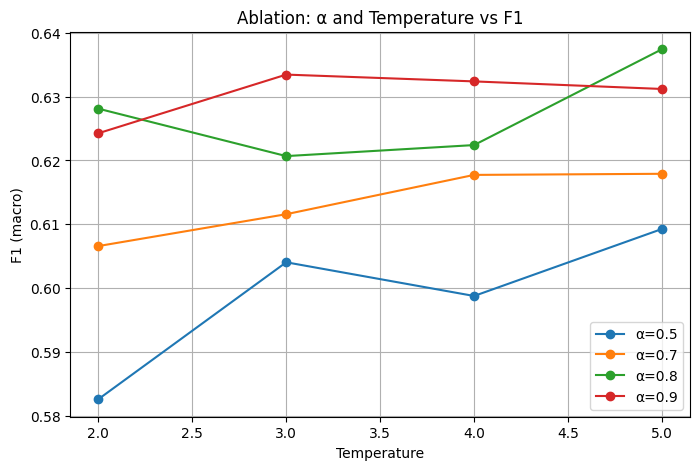

In [16]:
# =========================================================
# Ablation: α (alpha) and Temperature Sweep
# =========================================================
import pandas as pd

alphas = [0.5, 0.7, 0.8, 0.9]
temps  = [2.0, 3.0, 4.0, 5.0]
results = []

for a in alphas:
    for t in temps:
        print(f"\n=== Running KD: α={a}, T={t} ===")
        kd_trainer = KDTrainer(
            model=s_model,
            args=s_args,
            train_dataset=s_ds["train"],
            eval_dataset=s_ds["validation"],
            tokenizer=s_tokenizer,
            data_collator=kd_collator,
            compute_metrics=compute_metrics,
            alpha=a,
            temperature=t,
        )
        kd_trainer.train()
        metrics = kd_trainer.evaluate(s_ds["test"])
        metrics["alpha"], metrics["temperature"] = a, t
        results.append(metrics)

# Save and visualize results
df = pd.DataFrame(results)
display(df[["alpha", "temperature", "eval_accuracy", "eval_f1_macro"]])

plt.figure(figsize=(8, 5))
for a in alphas:
    subset = df[df["alpha"] == a]
    plt.plot(subset["temperature"], subset["eval_f1_macro"], marker="o", label=f"α={a}")
plt.xlabel("Temperature")
plt.ylabel("F1 (macro)")
plt.title("Ablation: α and Temperature vs F1")
plt.legend()
plt.grid(True)
plt.show()


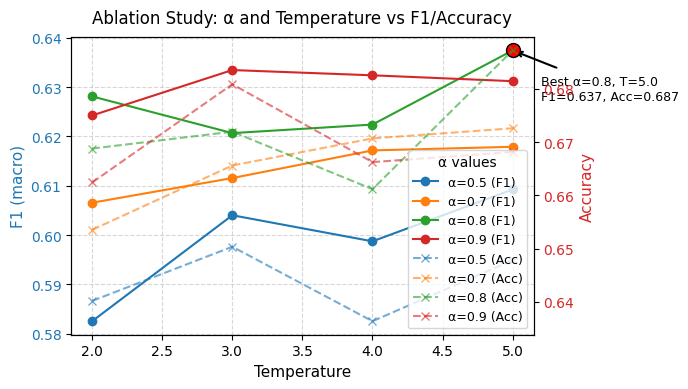

In [18]:
# 📊 Ablation: α and Temperature vs F1/Accuracy (with best point highlighted)
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Data
# ------------------------------
data = {
    "alpha": [0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7,
              0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9],
    "temperature": [2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0,
                    2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0],
    "eval_accuracy": [0.640178, 0.650350, 0.636364, 0.647807,
                      0.653528, 0.665607, 0.670693, 0.672600,
                      0.668786, 0.671964, 0.661157, 0.687222,
                      0.662428, 0.680865, 0.666243, 0.668150],
    "eval_f1_macro": [0.582562, 0.604032, 0.598748, 0.609252,
                      0.606574, 0.611569, 0.617171, 0.617904,
                      0.628115, 0.620678, 0.622408, 0.637435,
                      0.624260, 0.633457, 0.632391, 0.631204],
}
df = pd.DataFrame(data)

# ------------------------------
# Identify best F1 configuration
# ------------------------------
best_row = df.loc[df["eval_f1_macro"].idxmax()]
best_alpha = best_row["alpha"]
best_temp = best_row["temperature"]
best_f1 = best_row["eval_f1_macro"]
best_acc = best_row["eval_accuracy"]

# ------------------------------
# Plot
# ------------------------------
fig, ax1 = plt.subplots(figsize=(7, 4))

# Primary Y-axis (F1)
for alpha in sorted(df["alpha"].unique()):
    subset = df[df["alpha"] == alpha]
    ax1.plot(subset["temperature"], subset["eval_f1_macro"],
             marker='o', label=f"α={alpha} (F1)")

# Highlight best point
ax1.scatter(best_temp, best_f1, color='red', s=100, edgecolor='black', zorder=5)
ax1.annotate(
    f"Best α={best_alpha}, T={best_temp}\nF1={best_f1:.3f}, Acc={best_acc:.3f}",
    xy=(best_temp, best_f1),
    xytext=(best_temp + 0.2, best_f1 - 0.01),
    arrowprops=dict(arrowstyle="->", lw=1.5),
    fontsize=9,
    backgroundcolor='white'
)

ax1.set_xlabel("Temperature", fontsize=11)
ax1.set_ylabel("F1 (macro)", color='tab:blue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Secondary Y-axis (Accuracy)
ax2 = ax1.twinx()
for alpha in sorted(df["alpha"].unique()):
    subset = df[df["alpha"] == alpha]
    ax2.plot(subset["temperature"], subset["eval_accuracy"],
             marker='x', linestyle='--', alpha=0.6, label=f"α={alpha} (Acc)")

ax2.set_ylabel("Accuracy", color='tab:red', fontsize=11)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, title="α values", loc='lower right', fontsize=9)

plt.title("Ablation Study: α and Temperature vs F1/Accuracy", fontsize=12, pad=10)
plt.tight_layout()
plt.show()


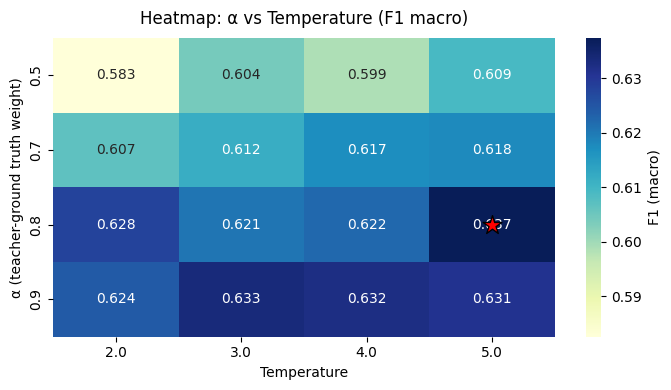

In [19]:
# 📊 Ablation Study: Heatmap + Line Plot for α and Temperature vs F1/Accuracy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Data
# ------------------------------
data = {
    "alpha": [0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7,
              0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9],
    "temperature": [2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0,
                    2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0],
    "eval_accuracy": [0.640178, 0.650350, 0.636364, 0.647807,
                      0.653528, 0.665607, 0.670693, 0.672600,
                      0.668786, 0.671964, 0.661157, 0.687222,
                      0.662428, 0.680865, 0.666243, 0.668150],
    "eval_f1_macro": [0.582562, 0.604032, 0.598748, 0.609252,
                      0.606574, 0.611569, 0.617171, 0.617904,
                      0.628115, 0.620678, 0.622408, 0.637435,
                      0.624260, 0.633457, 0.632391, 0.631204],
}

df = pd.DataFrame(data)

# ------------------------------
# Create heatmap pivot table (F1)
# ------------------------------
pivot_f1 = df.pivot(index="alpha", columns="temperature", values="eval_f1_macro")

# Find best configuration
best_row = df.loc[df["eval_f1_macro"].idxmax()]
best_alpha = best_row["alpha"]
best_temp = best_row["temperature"]
best_f1 = best_row["eval_f1_macro"]

# ------------------------------
# Plot: Heatmap
# ------------------------------
plt.figure(figsize=(7, 4))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'F1 (macro)'})
plt.title("Heatmap: α vs Temperature (F1 macro)", fontsize=12, pad=10)
plt.xlabel("Temperature")
plt.ylabel("α (teacher-ground truth weight)")

# Highlight best cell
plt.scatter(list(pivot_f1.columns).index(best_temp) + 0.5,
            list(pivot_f1.index).index(best_alpha) + 0.5,
            s=200, c="red", edgecolors="black", marker="*", zorder=5)

plt.tight_layout()
plt.show()


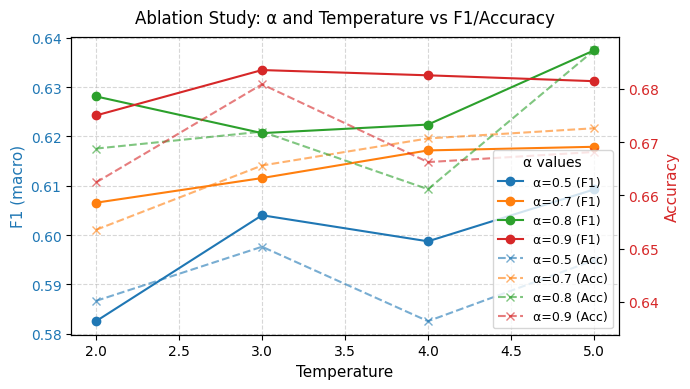

In [20]:
# 📊 Ablation: α and Temperature vs F1/Accuracy
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Data (from your ablation result)
# ------------------------------
data = {
    "alpha": [0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7,
              0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9],
    "temperature": [2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0,
                    2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0],
    "eval_accuracy": [0.640178, 0.650350, 0.636364, 0.647807,
                      0.653528, 0.665607, 0.670693, 0.672600,
                      0.668786, 0.671964, 0.661157, 0.687222,
                      0.662428, 0.680865, 0.666243, 0.668150],
    "eval_f1_macro": [0.582562, 0.604032, 0.598748, 0.609252,
                      0.606574, 0.611569, 0.617171, 0.617904,
                      0.628115, 0.620678, 0.622408, 0.637435,
                      0.624260, 0.633457, 0.632391, 0.631204],
}

df = pd.DataFrame(data)

# ------------------------------
# Plot
# ------------------------------
fig, ax1 = plt.subplots(figsize=(7, 4))

# Primary Y-axis: F1 (macro)
for alpha in sorted(df["alpha"].unique()):
    subset = df[df["alpha"] == alpha]
    ax1.plot(subset["temperature"], subset["eval_f1_macro"],
             marker='o', label=f"α={alpha} (F1)")

ax1.set_xlabel("Temperature", fontsize=11)
ax1.set_ylabel("F1 (macro)", color='tab:blue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Secondary Y-axis: Accuracy
ax2 = ax1.twinx()
for alpha in sorted(df["alpha"].unique()):
    subset = df[df["alpha"] == alpha]
    ax2.plot(subset["temperature"], subset["eval_accuracy"],
             marker='x', linestyle='--', alpha=0.6, label=f"α={alpha} (Acc)")

ax2.set_ylabel("Accuracy", color='tab:red', fontsize=11)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, title="α values", loc='lower right', fontsize=9)

plt.title("Ablation Study: α and Temperature vs F1/Accuracy", fontsize=12, pad=10)
plt.tight_layout()
plt.show()


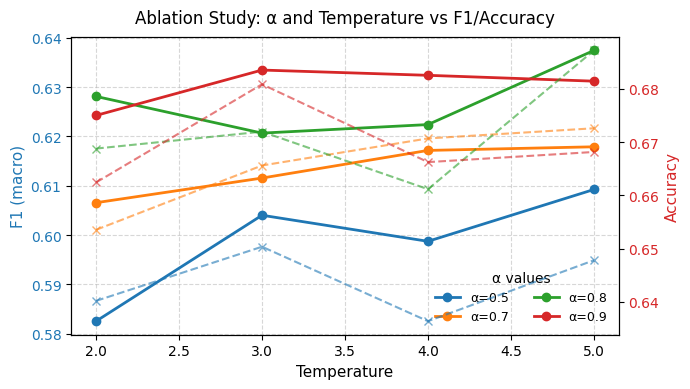

In [21]:
# 📊 Ablation: α and Temperature vs F1/Accuracy (Compact Legend)
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Data
# ------------------------------
data = {
    "alpha": [0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7,
              0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9],
    "temperature": [2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0,
                    2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0],
    "eval_accuracy": [0.640178, 0.650350, 0.636364, 0.647807,
                      0.653528, 0.665607, 0.670693, 0.672600,
                      0.668786, 0.671964, 0.661157, 0.687222,
                      0.662428, 0.680865, 0.666243, 0.668150],
    "eval_f1_macro": [0.582562, 0.604032, 0.598748, 0.609252,
                      0.606574, 0.611569, 0.617171, 0.617904,
                      0.628115, 0.620678, 0.622408, 0.637435,
                      0.624260, 0.633457, 0.632391, 0.631204],
}
df = pd.DataFrame(data)

# ------------------------------
# Plot
# ------------------------------
fig, ax1 = plt.subplots(figsize=(7, 4))

# F1 lines (solid)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i, alpha in enumerate(sorted(df["alpha"].unique())):
    subset = df[df["alpha"] == alpha]
    ax1.plot(subset["temperature"], subset["eval_f1_macro"],
             marker='o', color=colors[i], linewidth=2, label=f"α={alpha}")

ax1.set_xlabel("Temperature", fontsize=11)
ax1.set_ylabel("F1 (macro)", color='tab:blue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# Accuracy lines (dashed, same colors, lighter)
ax2 = ax1.twinx()
for i, alpha in enumerate(sorted(df["alpha"].unique())):
    subset = df[df["alpha"] == alpha]
    ax2.plot(subset["temperature"], subset["eval_accuracy"],
             marker='x', linestyle='--', color=colors[i], alpha=0.6)

ax2.set_ylabel("Accuracy", color='tab:red', fontsize=11)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Compact legend (F1 only, since color mapping shows α clearly)
ax1.legend(title="α values", loc='lower right', fontsize=9, ncol=2, frameon=False)

plt.title("Ablation Study: α and Temperature vs F1/Accuracy", fontsize=12, pad=10)
plt.tight_layout()
plt.show()


ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

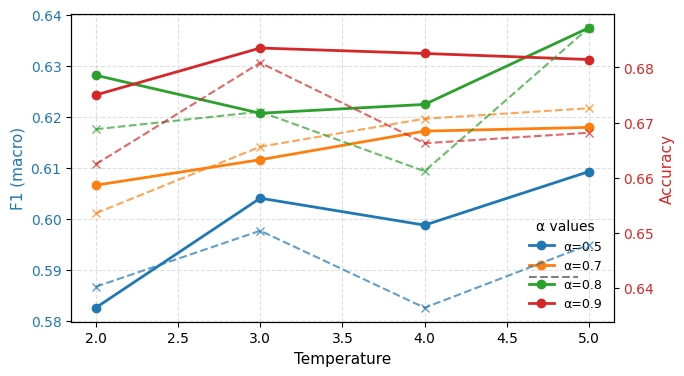

In [23]:
# 📊 Ablation: α and Temperature vs F1/Accuracy (Visual Accuracy Indicator)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ------------------------------
# Data
# ------------------------------
data = {
    "alpha": [0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7,
              0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9],
    "temperature": [2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0,
                    2.0, 3.0, 4.0, 5.0, 2.0, 3.0, 4.0, 5.0],
    "eval_accuracy": [0.640178, 0.650350, 0.636364, 0.647807,
                      0.653528, 0.665607, 0.670693, 0.672600,
                      0.668786, 0.671964, 0.661157, 0.687222,
                      0.662428, 0.680865, 0.666243, 0.668150],
    "eval_f1_macro": [0.582562, 0.604032, 0.598748, 0.609252,
                      0.606574, 0.611569, 0.617171, 0.617904,
                      0.628115, 0.620678, 0.622408, 0.637435,
                      0.624260, 0.633457, 0.632391, 0.631204],
}
df = pd.DataFrame(data)

# ------------------------------
# Plot setup
# ------------------------------
fig, ax1 = plt.subplots(figsize=(7, 4))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot F1 (solid)
for i, alpha in enumerate(sorted(df["alpha"].unique())):
    subset = df[df["alpha"] == alpha]
    ax1.plot(subset["temperature"], subset["eval_f1_macro"],
             marker='o', linewidth=2, color=colors[i], label=f"α={alpha}")

# Plot Accuracy (dashed)
ax2 = ax1.twinx()
for i, alpha in enumerate(sorted(df["alpha"].unique())):
    subset = df[df["alpha"] == alpha]
    ax2.plot(subset["temperature"], subset["eval_accuracy"],
             marker='x', linestyle='--', linewidth=1.5, color=colors[i], alpha=0.7)

# Axis labels
ax1.set_xlabel("Temperature", fontsize=11)
ax1.set_ylabel("F1 (macro)", color='tab:blue', fontsize=11)
ax2.set_ylabel("Accuracy", color='tab:red', fontsize=11)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True, linestyle='--', alpha=0.4)

# ✅ Clean legend (only α values)
legend = ax1.legend(title="α values", loc='lower right', fontsize=9, frameon=False)

# Add visual sample line for Accuracy below the legend (no text)
line = Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5)
ax1.add_artist(plt.legend(
    handles=[line],
    labels=[" "],  # invisible label, just space
    loc='lower right',
    bbox_to_anchor=(0.985, 0.08),  # adjust placement under legend
    frameon=False,
    handlelength=3.5
))

plt.title("Ablation Study: α and Temperature vs F1/Accuracy", fontsize=12, pad=10)
plt.tight_layout()
plt.show()
